In [1]:
import pandas as pd
import sqlite3
from vega_datasets import data
import geopandas as gpd
import os
import matplotlib.pyplot as plt

url = data.us_10m.url
states_gdf = gpd.read_file(url, layer="states")
counties_gdf = gpd.read_file(url, layer="counties")

# set global vars
db_name = "field_crops.db"
crop_table = "midwest_key_field_crops_cleaned"
area_table = "midwest_area_planted_cleaned"

In [3]:

# Configuration
DB_NAME = "field_crops.db"
CROP_TABLE = "midwest_key_field_crops_cleaned"
AREA_TABLE = "midwest_area_planted_cleaned"
OUTPUT_PATH = "../viz/"
MIDWESTERN_STATE_IDS = [17, 18, 19, 20, 26, 27, 29, 31, 38, 39, 46, 55]


def load_midwest_counties(conn, table, counties_gdf):
    """
    Load and filter counties GeoDataFrame for Midwestern states.
    """
    query = f"SELECT DISTINCT state_ansi FROM {table}"
    state_ansi_list = pd.read_sql(query, conn).iloc[:, 0].to_list()

    # Filter counties to only include Midwest states with valid county codes
    midwest_counties_gdf = counties_gdf[
        counties_gdf["id"].str[:2].isin(state_ansi_list)
        & (counties_gdf["id"].str.len() == 5)
    ]

    return midwest_counties_gdf


def get_production_data(conn, table, year_start, year_end):
    """
    Get average production data for a specific time period.
    """
    query = f"""
    SELECT 
        avg(value) AS avg_prod,
        commodity_desc,
        state_alpha, 
        state_ansi || county_ansi as id
    FROM {table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND asd_code != 99
        AND county_ansi != ""
        AND year BETWEEN {year_start} AND {year_end}
    GROUP BY state_ansi || county_ansi, commodity_desc
    """
    return pd.read_sql(query, conn)


def get_area_data(conn, table, year_start, year_end):
    """
    Get average area data for a specific time period.
    """
    query = f"""
    SELECT 
        avg(value) AS avg_area,
        commodity_desc,
        state_alpha,
        state_ansi || county_ansi as id
    FROM {table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND asd_code != 99
        AND county_ansi != ""
        AND year BETWEEN {year_start} AND {year_end}
    GROUP BY state_ansi || county_ansi, commodity_desc
    """
    return pd.read_sql(query, conn)


def calculate_yield_changes(prod_past, area_past, prod_present, area_present):
    """
    Calculate yield changes between two time periods.
    """
    # Calculate yields for each period
    yield_past = pd.merge(
        prod_past, area_past, on=["commodity_desc", "id", "state_alpha"]
    )
    yield_past["yield_past"] = yield_past["avg_prod"] / yield_past["avg_area"]

    yield_present = pd.merge(
        prod_present, area_present, on=["commodity_desc", "id", "state_alpha"]
    )
    yield_present["yield_present"] = (
        yield_present["avg_prod"] / yield_present["avg_area"]
    )

    # Calculate changes
    yield_change = pd.merge(
        yield_past, yield_present, on=["commodity_desc", "id", "state_alpha"]
    )
    yield_change["abs_change_yield"] = (
        yield_change["yield_present"] - yield_change["yield_past"]
    )
    yield_change["perc_change_yield"] = (
        (yield_change["yield_present"] - yield_change["yield_past"])
        / yield_change["yield_past"]
        * 100
    )

    return yield_change


def get_annual_corn_production(conn, table):
    """
    Get annual corn production data since 1975.
    """
    query = f"""
    SELECT 
        state_name,
        county_name,
        year,
        value AS annual_production,
        state_ansi || county_ansi as id
    FROM {table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """
    return pd.read_sql(query, conn)

In [4]:

url = data.us_10m.url
states_gdf = gpd.read_file(url, layer="states")
counties_gdf = gpd.read_file(url, layer="counties")

# Create output directories
os.makedirs(f"{OUTPUT_PATH}output_data", exist_ok=True)
os.makedirs(f"{OUTPUT_PATH}backgrounds", exist_ok=True)

# Create single connection object
conn = sqlite3.connect(DB_NAME)

production_query = f"""
SELECT 
    state_name,
    county_name,
    year,
    value AS annual_production,
    state_ansi || county_ansi as id
FROM {crop_table} 
WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
    AND commodity_desc = 'CORN'
    AND asd_code != 99
    AND county_ansi != ""
    and county_name = "POWESHIEK"
    AND year > 1975
order by year
"""

prod_df = pd.read_sql(production_query, conn)
prod_df


,state_name,county_name,year,annual_production,id
0,IOWA,POWESHIEK,1976,13007000.0,19157
1,IOWA,POWESHIEK,1977,10101000.0,19157
2,IOWA,POWESHIEK,1978,14350000.0,19157
3,IOWA,POWESHIEK,1979,15800000.0,19157
4,IOWA,POWESHIEK,1980,14500000.0,19157
5,IOWA,POWESHIEK,1981,17006000.0,19157
6,IOWA,POWESHIEK,1982,17771000.0,19157
7,IOWA,POWESHIEK,1983,6651000.0,19157
8,IOWA,POWESHIEK,1984,14259000.0,19157
9,IOWA,POWESHIEK,1985,14949000.0,19157


In [6]:
# Option 1
pd.read_sql("SELECT * FROM midwest_key_field_crops_cleaned LIMIT 1", conn)


,reference_period_desc,domain_desc,load_time,year,Value,short_desc,util_practice_desc,county_name,end_code,state_ansi,...,week_ending,watershed_desc,state_alpha,state_name,class_desc,begin_code,unit_desc,country_code,location_desc,group_desc
0,YEAR,TOTAL,2012-01-01 00:00:00.000,1969,26750200.0,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",GRAIN,BUREAU,00,17,...,,,IL,ILLINOIS,ALL CLASSES,00,BU,9000,"ILLINOIS, NORTHWEST, BUREAU",FIELD CROPS


In [7]:
def get_annual_data(conn, crop_table, area_table):
    """
    Get annual production and area data since 1975, and calculate yields.
    """
    production_query = f"""
    SELECT 
        state_name,
        county_name,
        year,
        value AS annual_production,
        state_ansi || county_ansi as id
    FROM {crop_table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        and county_name = "POWESHIEK"
        AND year > 1975
    """

    area_query = f"""
    SELECT 
        year,
        value AS annual_area,
        state_ansi || county_ansi as id
    FROM {area_table} 
    WHERE short_desc != 'CORN, SILAGE - ACRES HARVESTED'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """

    # Get production and area data
    prod_df = pd.read_sql(production_query, conn)
    area_df = pd.read_sql(area_query, conn)

    # Merge production and area data
    annual_data = pd.merge(prod_df, area_df, on=["id", "year"], how="outer")

    # Calculate yield
    annual_data["annual_yield"] = (
        annual_data["annual_production"] / annual_data["annual_area"]
    )

    return annual_data

In [53]:
# Get the annual data and calculate rolling averages as before
annual_data = get_annual_data(conn, CROP_TABLE, AREA_TABLE)
# Create complete time series
counties = annual_data["id"].unique()
years = pd.Series(range(1976, pd.to_datetime("today").year + 1))
all_combinations = pd.MultiIndex.from_product(
    [counties, years], names=["id", "year"]
)
all_combinations = pd.DataFrame(
    all_combinations.to_flat_index().tolist(), columns=["id", "year"]
)

annual_data = all_combinations.merge(annual_data, on=["id", "year"], how="left")
annual_data

,id,year,state_name,county_name,annual_production,annual_area,annual_yield
0,17001,1976,ILLINOIS,ADAMS,11222400.0,138600.0,80.969697
1,17001,1977,ILLINOIS,ADAMS,7672300.0,134200.0,57.170641
2,17001,1978,ILLINOIS,ADAMS,11129100.0,120100.0,92.665279
3,17001,1979,ILLINOIS,ADAMS,14860100.0,125100.0,118.785771
4,17001,1980,ILLINOIS,ADAMS,10242900.0,129800.0,78.912943
...,...,...,...,...,...,...,...
51592,55141,2020,WISCONSIN,WOOD,3620000.0,37800.0,95.767196
51593,55141,2021,WISCONSIN,WOOD,4492000.0,38700.0,116.072351
51594,55141,2022,WISCONSIN,WOOD,4248000.0,37100.0,114.501348
51595,55141,2023,WISCONSIN,WOOD,4522000.0,40800.0,110.833333


In [54]:


# Calculate 5-year rolling sums for both production and area
annual_data['rolling_production'] = annual_data.groupby('id')['annual_production'].transform(
    lambda x: x.rolling(window=5, min_periods=1).sum()
)
annual_data['rolling_area'] = annual_data.groupby('id')['annual_area'].transform(
    lambda x: x.rolling(window=5, min_periods=1).sum()
)

# Calculate yield based on rolling totals and round
annual_data['rolling_yield'] = (annual_data['rolling_production'] / annual_data['rolling_area']).round(2)

# Calculate percentile ranks within each year
annual_data['yield_percentile'] = annual_data.groupby('year')['rolling_yield'].transform(
    lambda x: x.rank(pct=True).round(2) * 100
).fillna(-1).astype(int)

annual_data['production_percentile'] = annual_data.groupby('year')['rolling_production'].transform(
    lambda x: x.rank(pct=True).round(2) * 100
).fillna(-1).astype(int)

# Clean up intermediate columns
annual_data = annual_data.drop(['rolling_area', 'annual_production', 'annual_area', 'annual_yield'], axis=1)

annual_data

,id,year,state_name,county_name,rolling_production,rolling_yield,yield_percentile,production_percentile
0,17001,1976,ILLINOIS,ADAMS,11222400.0,80.97,63,86
1,17001,1977,ILLINOIS,ADAMS,18894700.0,69.26,51,80
2,17001,1978,ILLINOIS,ADAMS,30023800.0,76.42,54,81
3,17001,1979,ILLINOIS,ADAMS,44883900.0,86.65,60,82
4,17001,1980,ILLINOIS,ADAMS,55126800.0,85.10,60,81
...,...,...,...,...,...,...,...,...
51592,55141,2020,WISCONSIN,WOOD,15077000.0,82.25,7,30
51593,55141,2021,WISCONSIN,WOOD,14637000.0,81.77,8,30
51594,55141,2022,WISCONSIN,WOOD,17542000.0,97.24,15,33
51595,55141,2023,WISCONSIN,WOOD,18842000.0,101.96,16,32


In [26]:
# mapping and filtering codes
noaa_midwest_codes = [
    "11",
    "12",
    "13",
    "14",
    "20",
    "21",
    "23",
    "25",
    "32",
    "33",
    "39",
    "47",
]
fips_mapping = {
    "11": "17",  # Illinois
    "12": "18",  # Indiana
    "13": "19",  # Iowa
    "14": "20",  # Kansas
    "20": "26",  # Michigan
    "21": "27",  # Minnesota
    "23": "29",  # Missouri
    "25": "31",  # Nebraska
    "32": "38",  # North Dakota
    "33": "39",  # Ohio
    "39": "46",  # South Dakota
    "47": "55",  # Wisconsin
}
final_df_cols = ["Year", "County_Code", "state_fips"]


# function to parse raw input data
def parse_climdiv_data(
    file_path,
    yearly_avg_column_name,
    midwest_codes=noaa_midwest_codes,
    final_df_cols=final_df_cols,
):
    column_specs = [
        (0, 2),  # STATE-CODE (1-2)
        (2, 5),  # DIVISION-NUMBER (3-5)
        (5, 7),  # ELEMENT CODE (6-7)
        (7, 11),  # YEAR (8-11)
        (11, 18),  # JAN-VALUE (12-18)
        (18, 25),  # FEB-VALUE (19-25)
        (25, 32),  # MAR-VALUE (26-32)
        (32, 39),  # APR-VALUE (33-39)
        (39, 46),  # MAY-VALUE (40-46)
        (46, 53),  # JUNE-VALUE (47-53)
        (53, 60),  # JULY-VALUE (54-60)
        (60, 67),  # AUG-VALUE (61-67)
        (67, 74),  # SEPT-VALUE (68-74)
        (74, 81),  # OCT-VALUE (75-81)
        (81, 88),  # NOV-VALUE (82-88)
        (88, 95),  # DEC-VALUE (89-95)
    ]

    column_names = [
        "State_Code",
        "Division_Number",
        "Element_Code",
        "Year",
        "Jan_Value",
        "Feb_Value",
        "Mar_Value",
        "Apr_Value",
        "May_Value",
        "Jun_Value",
        "Jul_Value",
        "Aug_Value",
        "Sep_Value",
        "Oct_Value",
        "Nov_Value",
        "Dec_Value",
    ]

    df = pd.read_fwf(
        file_path,
        colspecs=column_specs,
        names=column_names,
        dtype={"State_Code": str, "Division_Number": str},
    )

    df["state_fips"] = df["State_Code"].map(fips_mapping)
    df["County_Code"] = df["state_fips"] + df["Division_Number"]
    numeric_columns = column_names[4:]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

    # handle missing values
    df.replace(
        {
            "Jan_Value": {-99.99: None, -9.99: None},
            "Feb_Value": {-99.99: None, -9.99: None},
            "Mar_Value": {-99.99: None, -9.99: None},
            "Apr_Value": {-99.99: None, -9.99: None},
            "May_Value": {-99.99: None, -9.99: None},
            "Jun_Value": {-99.99: None, -9.99: None},
            "Jul_Value": {-99.99: None, -9.99: None},
            "Aug_Value": {-99.99: None, -9.99: None},
            "Sep_Value": {-99.99: None, -9.99: None},
            "Oct_Value": {-99.99: None, -9.99: None},
            "Nov_Value": {-99.99: None, -9.99: None},
            "Dec_Value": {-99.99: None, -9.99: None},
        },
        inplace=True,
    )

    df[yearly_avg_column_name] = df[numeric_columns].mean(axis=1)

    midwest_df = df[df["State_Code"].isin(midwest_codes)]

    midwest_df_post1950 = midwest_df[midwest_df["Year"] > 1950]

    output_columns = final_df_cols + [yearly_avg_column_name]

    return midwest_df_post1950[output_columns]


precipitation_path = "../data/climate_data/climdiv-pcpncy-v1.0.0-20241021.txt"
avg_temp_path = "../data/climate_data/climdiv-tmpccy-v1.0.0-20241021.txt"
max_temp_path = "../data/climate_data/climdiv-tmaxcy-v1.0.0-20241021.txt"
min_temp_path = "../data/climate_data/climdiv-tmincy-v1.0.0-20241021.txt"
precip_df = parse_climdiv_data(precipitation_path, "ann_avg_precip")
avg_temp_df = parse_climdiv_data(avg_temp_path, "ann_avg_temp")
max_temp_df = parse_climdiv_data(max_temp_path, "ann_max_temp")
min_temp_df = parse_climdiv_data(min_temp_path, "ann_min_temp")

merge_cols = ["Year", "County_Code", "state_fips"]
annual_climate_data_df = (
    precip_df.merge(avg_temp_df, on=merge_cols)
    .merge(max_temp_df, on=merge_cols)
    .merge(min_temp_df, on=merge_cols)
)
annual_climate_data_df = annual_climate_data_df.sort_values(by=["County_Code", "Year"])

rolling_avg_30yr_climate_data_df = (
    annual_climate_data_df.groupby("County_Code")[
        ["Year", "ann_avg_precip", "ann_avg_temp", "ann_max_temp", "ann_min_temp"]
    ]
    .apply(lambda x: x.set_index("Year").rolling(window=30).mean())
    .reset_index()
)

rolling_avg_30yr_climate_data_df.rename(columns={"County_Code": "id", "Year": "year"}, inplace=True)



In [60]:
merged_df = pd.merge(annual_data, rolling_avg_30yr_climate_data_df, on=['id', 'year'], how='left')
merged_df

,id,year,state_name,county_name,rolling_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,ann_max_temp,ann_min_temp
0,17001,1976,ILLINOIS,ADAMS,11222400.0,80.97,63,86,NaN,NaN,NaN,NaN
1,17001,1977,ILLINOIS,ADAMS,18894700.0,69.26,51,80,NaN,NaN,NaN,NaN
2,17001,1978,ILLINOIS,ADAMS,30023800.0,76.42,54,81,NaN,NaN,NaN,NaN
3,17001,1979,ILLINOIS,ADAMS,44883900.0,86.65,60,82,NaN,NaN,NaN,NaN
4,17001,1980,ILLINOIS,ADAMS,55126800.0,85.10,60,81,3.077528,52.004722,62.347222,41.651944
...,...,...,...,...,...,...,...,...,...,...,...,...
51592,55141,2020,WISCONSIN,WOOD,15077000.0,82.25,7,30,2.766056,44.017500,54.503611,33.534722
51593,55141,2021,WISCONSIN,WOOD,14637000.0,81.77,8,30,2.774861,44.102778,54.588611,33.622222
51594,55141,2022,WISCONSIN,WOOD,17542000.0,97.24,15,33,2.779000,44.116944,54.622778,33.616111
51595,55141,2023,WISCONSIN,WOOD,18842000.0,101.96,16,32,2.771361,44.290556,54.809167,33.777500


In [66]:
# Calculate percentile ranks within each year
merged_df['precip_percentile'] = merged_df.groupby('year')['ann_avg_precip'].transform(
    lambda x: x.rank(pct=True).round(2) * 100
).fillna(-1).astype(int)

merged_df['temp_percentile'] = merged_df.groupby('year')['ann_avg_temp'].transform(
    lambda x: x.rank(pct=True).round(2) * 100
).fillna(-1).astype(int)

merged_df

,id,year,state_name,county_name,rolling_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,ann_max_temp,ann_min_temp,precip_percentile,temp_percentile
0,17001,1976,ILLINOIS,ADAMS,11222400.0,80.97,63,86,NaN,NaN,NaN,NaN,-1,-1
1,17001,1977,ILLINOIS,ADAMS,18894700.0,69.26,51,80,NaN,NaN,NaN,NaN,-1,-1
2,17001,1978,ILLINOIS,ADAMS,30023800.0,76.42,54,81,NaN,NaN,NaN,NaN,-1,-1
3,17001,1979,ILLINOIS,ADAMS,44883900.0,86.65,60,82,NaN,NaN,NaN,NaN,-1,-1
4,17001,1980,ILLINOIS,ADAMS,55126800.0,85.10,60,81,3.077528,52.004722,62.347222,41.651944,77,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51592,55141,2020,WISCONSIN,WOOD,15077000.0,82.25,7,30,2.766056,44.017500,54.503611,33.534722,40,15
51593,55141,2021,WISCONSIN,WOOD,14637000.0,81.77,8,30,2.774861,44.102778,54.588611,33.622222,41,15
51594,55141,2022,WISCONSIN,WOOD,17542000.0,97.24,15,33,2.779000,44.116944,54.622778,33.616111,42,16
51595,55141,2023,WISCONSIN,WOOD,18842000.0,101.96,16,32,2.771361,44.290556,54.809167,33.777500,42,16


In [67]:
# Process corn data
midwest_counties_gdf = load_midwest_counties(conn, CROP_TABLE, counties_gdf)
merged = gpd.GeoDataFrame(
    pd.merge(merged_df, midwest_counties_gdf, on="id", how="left")
)
merged.set_geometry("geometry", inplace=True)
merged

,id,year,state_name,county_name,rolling_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,ann_max_temp,ann_min_temp,precip_percentile,temp_percentile,geometry
0,17001,1976,ILLINOIS,ADAMS,11222400.0,80.97,63,86,NaN,NaN,NaN,NaN,-1,-1,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
1,17001,1977,ILLINOIS,ADAMS,18894700.0,69.26,51,80,NaN,NaN,NaN,NaN,-1,-1,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
2,17001,1978,ILLINOIS,ADAMS,30023800.0,76.42,54,81,NaN,NaN,NaN,NaN,-1,-1,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
3,17001,1979,ILLINOIS,ADAMS,44883900.0,86.65,60,82,NaN,NaN,NaN,NaN,-1,-1,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
4,17001,1980,ILLINOIS,ADAMS,55126800.0,85.10,60,81,3.077528,52.004722,62.347222,41.651944,77,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52082,55141,2020,WISCONSIN,WOOD,15077000.0,82.25,7,30,2.766056,44.017500,54.503611,33.534722,40,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
52083,55141,2021,WISCONSIN,WOOD,14637000.0,81.77,8,30,2.774861,44.102778,54.588611,33.622222,41,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
52084,55141,2022,WISCONSIN,WOOD,17542000.0,97.24,15,33,2.779000,44.116944,54.622778,33.616111,42,16,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
52085,55141,2023,WISCONSIN,WOOD,18842000.0,101.96,16,32,2.771361,44.290556,54.809167,33.777500,42,16,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."


In [70]:
output_df = merged[(merged["year"] >= 1980) & (merged["year"] <= 2023)]
output_df.set_crs("EPSG:4326", inplace=True)

/Users/jacobtrout/Library/Caches/pypoetry/virtualenvs/30239-notes-jAgAN4Ls-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,year,state_name,county_name,rolling_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,ann_max_temp,ann_min_temp,precip_percentile,temp_percentile,geometry
4,17001,1980,ILLINOIS,ADAMS,55126800.0,85.10,60,81,3.077528,52.004722,62.347222,41.651944,77,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
5,17001,1981,ILLINOIS,ADAMS,57923600.0,91.18,62,81,3.100972,52.083611,62.430000,41.726944,78,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
6,17001,1982,ILLINOIS,ADAMS,65260400.0,104.23,75,84,3.144056,52.011944,62.319444,41.693056,79,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
7,17001,1983,ILLINOIS,ADAMS,58675800.0,95.75,68,83,3.184917,51.945000,62.195278,41.684444,80,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
8,17001,1984,ILLINOIS,ADAMS,55422900.0,91.17,61,82,3.216028,51.889167,62.111389,41.657778,80,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52081,55141,2019,WISCONSIN,WOOD,14754000.0,80.71,7,30,2.773111,44.004167,54.515833,33.498056,40,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
52082,55141,2020,WISCONSIN,WOOD,15077000.0,82.25,7,30,2.766056,44.017500,54.503611,33.534722,40,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
52083,55141,2021,WISCONSIN,WOOD,14637000.0,81.77,8,30,2.774861,44.102778,54.588611,33.622222,41,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
52084,55141,2022,WISCONSIN,WOOD,17542000.0,97.24,15,33,2.779000,44.116944,54.622778,33.616111,42,16,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."


In [71]:
# Check for missing values in the DataFrame
missing_values_summary = output_df.isnull().sum()

# Print the summary of missing values
print(missing_values_summary)

id                          0
year                        0
state_name               5182
county_name              5182
rolling_production       2099
rolling_yield            2099
yield_percentile            0
production_percentile       0
ann_avg_precip             88
ann_avg_temp               88
ann_max_temp               88
ann_min_temp               88
precip_percentile           0
temp_percentile             0
geometry                  132
dtype: int64


In [72]:
# Show rows where county_name is missing
missing_counties = output_df[output_df['county_name'].isnull()]

# Display the count of missing counties
print(f"Number of rows with missing county names: {len(missing_counties)}")

# Display the first few rows of the filtered data
print("\nSample of rows with missing county names:")
print(missing_counties[['id', 'year', 'state_name', 'county_name']].head())

Number of rows with missing county names: 5182

Sample of rows with missing county names:
       id  year state_name county_name
45  17001  2021        NaN         NaN
85  17003  2012        NaN         NaN
86  17003  2013        NaN         NaN
88  17003  2015        NaN         NaN
94  17003  2021        NaN         NaN


In [ ]:

output_df.set_crs("EPSG:4326", inplace=True)

output_df.to_file("output_data.geojson", driver="GeoJSON")
output_dir = "output_data"
os.makedirs(output_dir, exist_ok=True)
for year in output_df["Year"].unique():
    year_df = output_df[output_df["Year"] == year]
    year_filename = os.path.join(output_dir, f"output_{year}.geojson")
    year_df.to_file(year_filename, driver="GeoJSON")

testing

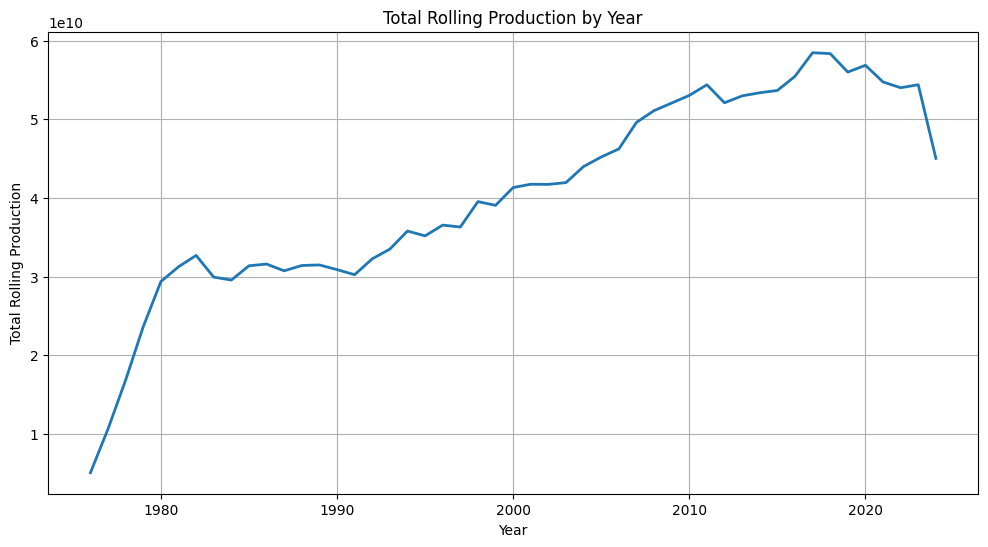

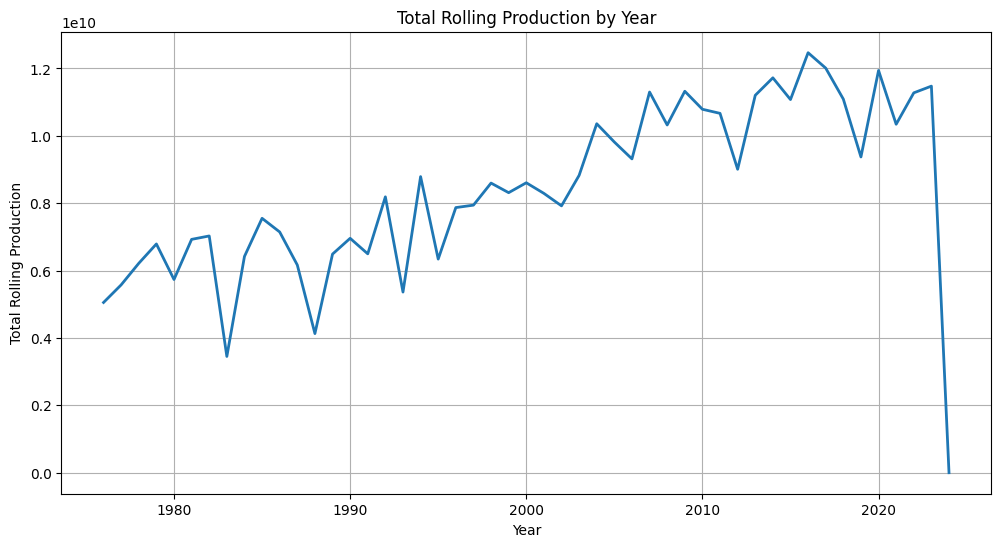

In [77]:
# Load data
url = data.us_10m.url
states_gdf = gpd.read_file(url, layer="states")
counties_gdf = gpd.read_file(url, layer="counties")

# Configuration
DB_NAME = "field_crops.db"
CROP_TABLE = "midwest_key_field_crops_cleaned"
AREA_TABLE = "midwest_area_planted_cleaned"
OUTPUT_PATH = "../viz/"
MIDWESTERN_STATE_IDS = [17, 18, 19, 20, 26, 27, 29, 31, 38, 39, 46, 55]


def load_midwest_counties(conn, table, counties_gdf):
    query = f"SELECT DISTINCT state_ansi FROM {table}"
    state_ansi_list = pd.read_sql(query, conn).iloc[:, 0].to_list()
    midwest_counties_gdf = counties_gdf[
        counties_gdf["id"].str[:2].isin(state_ansi_list)
        & (counties_gdf["id"].str.len() == 5)
    ]
    return midwest_counties_gdf


def get_annual_corn_production(conn, table):
    query = f"""
    SELECT 
        state_name,
        county_name,
        year,
        value AS annual_production,
        state_ansi || county_ansi as id
    FROM {table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """
    return pd.read_sql(query, conn)


def get_annual_data(conn, crop_table, area_table):
    production_query = f"""
    SELECT 
        state_name,
        county_name,
        year,
        value AS annual_production,
        state_ansi || county_ansi as id
    FROM {crop_table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """

    area_query = f"""
    SELECT 
        year,
        value AS annual_area,
        state_ansi || county_ansi as id
    FROM {area_table} 
    WHERE short_desc != 'CORN, SILAGE - ACRES HARVESTED'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """

    prod_df = pd.read_sql(production_query, conn)
    area_df = pd.read_sql(area_query, conn)

    annual_data = pd.merge(prod_df, area_df, on=["id", "year"], how="outer")
    annual_data["annual_yield"] = (
        annual_data["annual_production"] / annual_data["annual_area"]
    )

    return annual_data


# Create output directories
os.makedirs(f"{OUTPUT_PATH}output_data", exist_ok=True)
os.makedirs(f"{OUTPUT_PATH}backgrounds", exist_ok=True)

# Create single connection object
conn = sqlite3.connect(DB_NAME)

# Get the annual data and calculate rolling averages
annual_data = get_annual_data(conn, CROP_TABLE, AREA_TABLE)
counties = annual_data["id"].unique()
years = pd.Series(range(1976, pd.to_datetime("today").year + 1))
all_combinations = pd.MultiIndex.from_product([counties, years], names=["id", "year"])
all_combinations = pd.DataFrame(
    all_combinations.to_flat_index().tolist(), columns=["id", "year"]
)

annual_data = all_combinations.merge(annual_data, on=["id", "year"], how="left")

# Calculate 5-year rolling sums for both production and area
annual_data["rolling_production"] = annual_data.groupby("id")[
    "annual_production"
].transform(lambda x: x.rolling(window=5, min_periods=1).sum())
annual_data["rolling_area"] = annual_data.groupby("id")["annual_area"].transform(
    lambda x: x.rolling(window=5, min_periods=1).sum()
)

# Calculate total rolling production by year
yearly_total_production = annual_data.groupby('year')['rolling_production'].sum().reset_index()

# Create line chart using pandas plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_total_production['year'], yearly_total_production['rolling_production'], linewidth=2)
plt.title('Total Rolling Production by Year')
plt.xlabel('Year')
plt.ylabel('Total Rolling Production')
plt.grid(True)
plt.show()


yearly_total_production = annual_data.groupby('year')['annual_production'].sum().reset_index()
# Create line chart using pandas plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_total_production['year'], yearly_total_production['annual_production'], linewidth=2)
plt.title('Total Rolling Production by Year')
plt.xlabel('Year')
plt.ylabel('Total Rolling Production')
plt.grid(True)
plt.show()

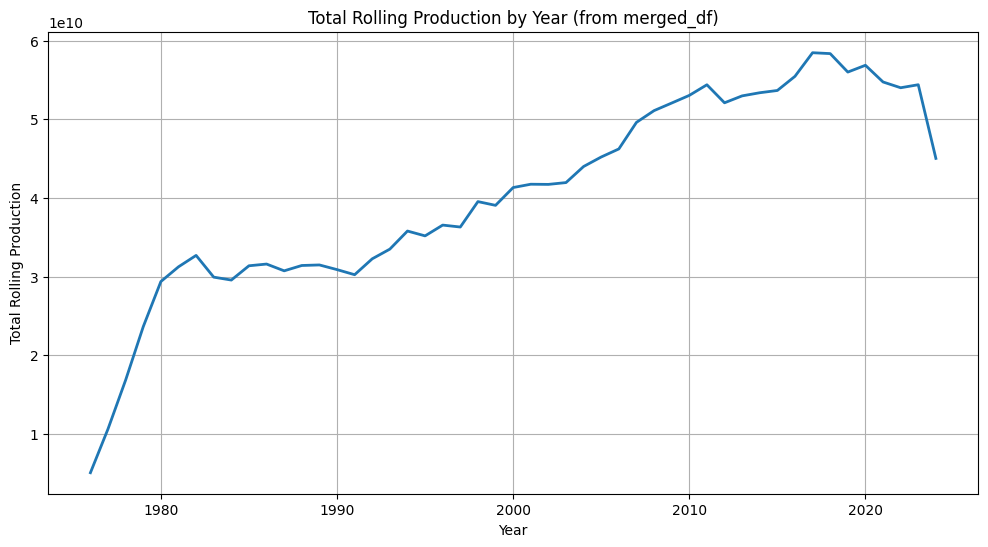

In [78]:
# Calculate yield based on rolling totals and round
annual_data["rolling_yield"] = (
    annual_data["rolling_production"] / annual_data["rolling_area"]
).round(2)

# Calculate percentile ranks within each year
annual_data["yield_percentile"] = (
    annual_data.groupby("year")["rolling_yield"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

annual_data["production_percentile"] = (
    annual_data.groupby("year")["rolling_production"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

# Clean up intermediate columns
annual_data = annual_data.drop(
    ["rolling_area", "annual_production", "annual_area", "annual_yield"], axis=1
)

# Merge data
merged_df = pd.merge(
    annual_data, rolling_avg_30yr_climate_data_df, on=["id", "year"], how="left"
)

# Calculate total rolling production by year from merged_df
yearly_total_merged = merged_df.groupby('year')['rolling_production'].sum().reset_index()

# Create line chart using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(yearly_total_merged['year'], yearly_total_merged['rolling_production'], linewidth=2)
plt.title('Total Rolling Production by Year (from merged_df)')
plt.xlabel('Year')
plt.ylabel('Total Rolling Production')
plt.grid(True)
plt.show()

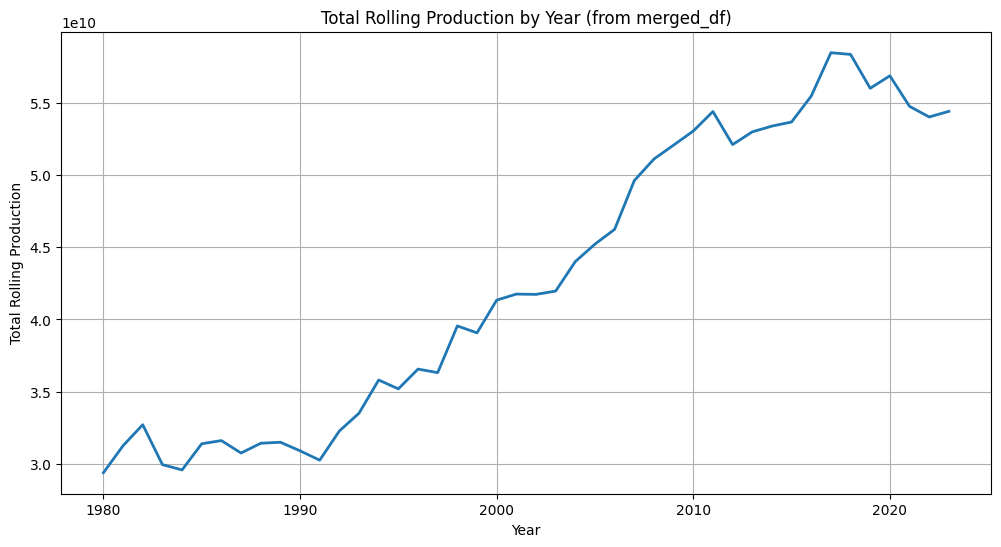

In [79]:

# Calculate percentile ranks within each year
merged_df["precip_percentile"] = (
    merged_df.groupby("year")["ann_avg_precip"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

merged_df["temp_percentile"] = (
    merged_df.groupby("year")["ann_avg_temp"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

# Process corn data
midwest_counties_gdf = load_midwest_counties(conn, CROP_TABLE, counties_gdf)
merged = gpd.GeoDataFrame(
    pd.merge(merged_df, midwest_counties_gdf, on="id", how="left")
)
merged.set_geometry("geometry", inplace=True)

# Filter data
output_df = merged[(merged["year"] >= 1980) & (merged["year"] <= 2023)]

# Calculate total rolling production by year from merged_df
yearly_total_merged = output_df.groupby('year')['rolling_production'].sum().reset_index()

# Create line chart using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(yearly_total_merged['year'], yearly_total_merged['rolling_production'], linewidth=2)
plt.title('Total Rolling Production by Year (from merged_df)')
plt.xlabel('Year')
plt.ylabel('Total Rolling Production')
plt.grid(True)
plt.show()

In [83]:
import pandas as pd
import sqlite3
from vega_datasets import data
import geopandas as gpd
import os

url = data.us_10m.url
states_gdf = gpd.read_file(url, layer="states")
counties_gdf = gpd.read_file(url, layer="counties")

# set global vars
db_name = "field_crops.db"
crop_table = "midwest_key_field_crops_cleaned"
area_table = "midwest_area_planted_cleaned"
output_path = "../static_final/"

# db connection
conn = sqlite3.connect(db_name)


def load_midwest_counties(conn, table, counties_gdf):
    # Fetch distinct state_ansi values as a list
    query = f"SELECT DISTINCT state_ansi FROM {table}"
    state_ansi_list = pd.read_sql(query, conn).squeeze().tolist()

    # Filter counties based on state_ansi and id length
    midwest_counties_gdf = counties_gdf[
        counties_gdf["id"].str[:2].isin(state_ansi_list) & (counties_gdf["id"].str.len() == 5)
    ]
    
    # Remove duplicated 'id' values
    midwest_counties_gdf_no_duplicates = midwest_counties_gdf.drop_duplicates(subset='id', keep=False)

    # Group duplicated counties and merge geometries
    duplicated_counties_gdf = midwest_counties_gdf[midwest_counties_gdf.duplicated('id', keep=False)]
    results = [
        {'id': county, 'geometry': county_records.geometry.unary_union}
        for county, county_records in duplicated_counties_gdf.groupby('id')
    ]

    # Create GeoDataFrame for merged geometries
    duplicated_counties_multi_gdf = gpd.GeoDataFrame(results, crs=counties_gdf.crs)

    # Concatenate and return the final GeoDataFrame
    final_counties_gdf = pd.concat([midwest_counties_gdf_no_duplicates, duplicated_counties_multi_gdf], ignore_index=True)
    final_counties_gdf = gpd.GeoDataFrame(final_counties_gdf, crs=counties_gdf.crs)

    return final_counties_gdf


midwestern_state_ids = [17, 18, 19, 20, 26, 27, 29, 31, 38, 39, 46, 55]


# pull in production and area data by county for begin and end of period
query = f"""
Select 
    avg(value) AS avg_prod_present,
    commodity_desc,
    state_alpha, 
    state_ansi|| county_ansi as id
from {crop_table} 
where short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
and asd_code != 99
and county_ansi != ""
and year between 2018 and 2023
group by state_ansi|| county_ansi, commodity_desc
"""

# pull in production and area data by county for begin and end of period
query = f"""
Select 
    avg(value) AS avg_prod_present,
    commodity_desc,
    state_alpha, 
    state_ansi|| county_ansi as id
from {crop_table} 
where short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
and asd_code != 99
and county_ansi != ""
and year between 2018 and 2023
group by state_ansi|| county_ansi, commodity_desc
"""
avg_prod_present = pd.read_sql(query, conn)

query = f"""
Select 
    avg(value) AS avg_prod_past,
    commodity_desc,
    state_alpha,
    state_ansi|| county_ansi as id
from {crop_table} 
where short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
and asd_code != 99
and county_ansi != ""
and year between 1975 and 1980
group by state_ansi|| county_ansi, commodity_desc
"""
avg_prod_past = pd.read_sql(query, conn)
query = f"""
Select 
    avg(value) AS avg_area_present,
    commodity_desc,
    state_alpha,
    state_ansi|| county_ansi as id
from {area_table} 
where short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
and asd_code != 99
and county_ansi != ""
and year between 2018 and 2023
group by state_ansi|| county_ansi , commodity_desc
"""
avg_area_present = pd.read_sql(query, conn)
query = f"""
Select 
    avg(value) AS avg_area_past,
    commodity_desc,
    state_alpha,
    state_ansi|| county_ansi as id
from {area_table} 
where short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
and asd_code != 99
and county_ansi != ""
and year between 1975 and 1980
group by state_ansi|| county_ansi , commodity_desc
"""
avg_area_past = pd.read_sql(query, conn)

# calc yield
avg_yield_past = pd.merge(
    avg_prod_past, avg_area_past, on=["commodity_desc", "id", "state_alpha"]
)
avg_yield_past["yield_past"] = (
    avg_yield_past["avg_prod_past"] / avg_yield_past["avg_area_past"]
)
avg_yield_present = pd.merge(
    avg_prod_present, avg_area_present, on=["commodity_desc", "id", "state_alpha"]
)
avg_yield_present["yield_present"] = (
    avg_yield_present["avg_prod_present"] / avg_yield_present["avg_area_present"]
)

# calc change in yield
yield_change = pd.merge(
    avg_yield_past, avg_yield_present, on=["commodity_desc", "id", "state_alpha"]
)
yield_change["abs_change_yield"] = (
    yield_change["yield_present"] - yield_change["yield_past"]
)
yield_change["perc_change_yield"] = (
    (yield_change["yield_present"] - yield_change["yield_past"])
    / yield_change["yield_past"]
) * 100

# make geopandas df with yield info
midwest_counties_gdf = load_midwest_counties(db_name, crop_table, counties_gdf)
merged = gpd.GeoDataFrame(
    pd.merge(yield_change, midwest_counties_gdf, on="id", how="left")
)
merged.set_geometry("geometry", inplace=True)

corn_df = merged[merged["commodity_desc"] == "CORN"]

output_df = corn_df[["geometry", "avg_prod_present"]]

corn_df.to_csv("test.csv", index=False)


# Annnual Corn Production since 1975
query = f"""
Select 
    state_name,
    county_name,
    year,
    value AS annual_production,
    state_ansi|| county_ansi as id
from {crop_table} 
where short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
and commodity_desc = 'CORN'
and asd_code != 99
and county_ansi != ""
and year > 1975
"""
ann_prod_corn = pd.read_sql(query, conn)

# Generate a DataFrame with every combination of id and year
counties = ann_prod_corn["id"].unique()
years = pd.Series(
    range(1976, pd.to_datetime("today").year + 1)
)  # Years from 1976 to current year

# Create MultiIndex and convert to DataFrame
all_combinations = pd.MultiIndex.from_product([counties, years], names=["id", "Year"])
all_combinations = pd.DataFrame(
    all_combinations.to_flat_index().tolist(), columns=["id", "Year"]
)

# Merge with the original DataFrame
ann_prod_corn["Year"] = ann_prod_corn["year"]
full_data = all_combinations.merge(ann_prod_corn, on=["id", "Year"], how="left")

# Calculate rolling averages (5-year window)
full_data["fiveyr_rolling_avg"] = (
    full_data.sort_values(by=["id", "Year"])
    .groupby("id")["annual_production"]
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


midwest_counties_gdf = load_midwest_counties(db_name, crop_table, counties_gdf)

# merge with geo data
merged = gpd.GeoDataFrame(
    pd.merge(full_data, midwest_counties_gdf, on="id", how="left")
)

output_df = merged[
    [
        "id",
        "state_name",
        "county_name",
        "Year",
        "annual_production",
        "fiveyr_rolling_avg",
        "geometry",
    ]
]
output_df = output_df[output_df["Year"] >= 1980]

# Add this line to rename the column
output_df = output_df.rename(columns={"fiveyr_rolling_avg": "rolling_production"})


# output_df = output_df[~output_df["fiveyr_rolling_avg"].isna()]

output_df.set_crs("EPSG:4326", inplace=True)

# output_df.to_file("output_data.geojson", driver="GeoJSON")
output_dir = "output_data"
os.makedirs(output_dir, exist_ok=True)


for year in output_df["Year"].unique():
    year_df = output_df[output_df["Year"] == year]
    year_filename = os.path.join(f"{OUTPUT_PATH}output_data", f"output_{year}.geojson")
    year_df.to_file(year_filename, driver="GeoJSON")


midwest_counties_gdf.set_crs("EPSG:4326", inplace=True)
midwest_counties_gdf.to_file("counties.geojson", driver="GeoJSON")
print(states_gdf.dtypes)
midwest_states_gdf = states_gdf[states_gdf["id"].astype(int).isin(midwestern_state_ids)]

print(midwest_states_gdf.head())
# midwest_states_gdf = load_midwest_counties(db_name, crop_table, counties_gdf)
midwest_states_gdf.set_crs("EPSG:4326", inplace=True)
midwest_states_gdf.to_file("states.geojson", driver="GeoJSON")

states_gdf.set_crs("EPSG:4326", inplace=True)
states_gdf.to_file("all_states.geojson", driver="GeoJSON")

/Users/jacobtrout/Library/Caches/pypoetry/virtualenvs/30239-notes-jAgAN4Ls-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/jacobtrout/Library/Caches/pypoetry/virtualenvs/30239-notes-jAgAN4Ls-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


id            object
geometry    geometry
dtype: object
    id                                           geometry
13  19  POLYGON ((-91.21681 43.50074, -91.20605 43.422...
15  17  POLYGON ((-90.42717 42.507, -89.92467 42.50593...
16  18  POLYGON ((-85.78621 41.75929, -85.66059 41.759...
17  20  POLYGON ((-101.41041 40.00226, -101.32427 40.0...
23  26  MULTIPOLYGON (((-86.00516 45.05418, -86.059 45...


/Users/jacobtrout/Library/Caches/pypoetry/virtualenvs/30239-notes-jAgAN4Ls-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [99]:
import pandas as pd
import sqlite3
from vega_datasets import data
import geopandas as gpd
import os

# Load data
url = data.us_10m.url
states_gdf = gpd.read_file(url, layer="states")
counties_gdf = gpd.read_file(url, layer="counties")

# Configuration
DB_NAME = "field_crops.db"
CROP_TABLE = "midwest_key_field_crops_cleaned"
AREA_TABLE = "midwest_area_planted_cleaned"
OUTPUT_PATH = "../viz/"
MIDWESTERN_STATE_IDS = [17, 18, 19, 20, 26, 27, 29, 31, 38, 39, 46, 55]


def load_midwest_counties(conn, table, counties_gdf):
    # Fetch distinct state_ansi values as a list
    query = f"SELECT DISTINCT state_ansi FROM {table}"
    state_ansi_list = pd.read_sql(query, conn).squeeze().tolist()

    # Filter counties based on state_ansi and id length
    midwest_counties_gdf = counties_gdf[
        counties_gdf["id"].str[:2].isin(state_ansi_list) & (counties_gdf["id"].str.len() == 5)
    ]
    
    # Remove duplicated 'id' values
    midwest_counties_gdf_no_duplicates = midwest_counties_gdf.drop_duplicates(subset='id', keep=False)

    # Group duplicated counties and merge geometries
    duplicated_counties_gdf = midwest_counties_gdf[midwest_counties_gdf.duplicated('id', keep=False)]
    results = [
        {'id': county, 'geometry': county_records.geometry.unary_union}
        for county, county_records in duplicated_counties_gdf.groupby('id')
    ]

    # Create GeoDataFrame for merged geometries
    duplicated_counties_multi_gdf = gpd.GeoDataFrame(results, crs=counties_gdf.crs)

    # Concatenate and return the final GeoDataFrame
    final_counties_gdf = pd.concat([midwest_counties_gdf_no_duplicates, duplicated_counties_multi_gdf], ignore_index=True)
    final_counties_gdf = gpd.GeoDataFrame(final_counties_gdf, crs=counties_gdf.crs)

    return final_counties_gdf




def get_annual_corn_production(conn, table):
    query = f"""
    SELECT 
        state_name,
        county_name,
        year,
        value AS annual_production,
        state_ansi || county_ansi as id
    FROM {table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """
    return pd.read_sql(query, conn)


def get_annual_data(conn, crop_table, area_table):
    production_query = f"""
    SELECT 
        state_name,
        county_name,
        year,
        value AS annual_production,
        state_ansi || county_ansi as id
    FROM {crop_table} 
    WHERE short_desc != 'CORN, SILAGE - PRODUCTION, MEASURED IN TONS'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """

    area_query = f"""
    SELECT 
        year,
        value AS annual_area,
        state_ansi || county_ansi as id
    FROM {area_table} 
    WHERE short_desc != 'CORN, SILAGE - ACRES HARVESTED'
        AND commodity_desc = 'CORN'
        AND asd_code != 99
        AND county_ansi != ""
        AND year > 1975
    """

    prod_df = pd.read_sql(production_query, conn)
    area_df = pd.read_sql(area_query, conn)

    annual_data = pd.merge(prod_df, area_df, on=["id", "year"], how="outer")
    annual_data["annual_yield"] = (
        annual_data["annual_production"] / annual_data["annual_area"]
    )

    return annual_data


# Create output directories
os.makedirs(f"{OUTPUT_PATH}output_data", exist_ok=True)
os.makedirs(f"{OUTPUT_PATH}backgrounds", exist_ok=True)

# Create single connection object
conn = sqlite3.connect(DB_NAME)

# Get the annual data and calculate rolling averages
annual_data = get_annual_data(conn, CROP_TABLE, AREA_TABLE)
counties = annual_data["id"].unique()
years = pd.Series(range(1976, pd.to_datetime("today").year + 1))
all_combinations = pd.MultiIndex.from_product([counties, years], names=["id", "year"])
all_combinations = pd.DataFrame(
    all_combinations.to_flat_index().tolist(), columns=["id", "year"]
)

annual_data = all_combinations.merge(annual_data, on=["id", "year"], how="left")

# Calculate 5-year rolling sums for both production and area
annual_data["rolling_production"] = annual_data.groupby("id")[
    "annual_production"
].transform(lambda x: x.rolling(window=5, min_periods=1).sum())
annual_data["rolling_area"] = annual_data.groupby("id")["annual_area"].transform(
    lambda x: x.rolling(window=5, min_periods=1).sum()
)

# Add rolling average production calculation
annual_data["rolling_avg_production"] = (
    annual_data.groupby("id")["annual_production"]
    .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    .round(2)
)

# Calculate yield based on rolling totals and round
annual_data["rolling_yield"] = (
    annual_data["rolling_production"] / annual_data["rolling_area"]
).round(2)

# Calculate percentile ranks within each year
annual_data["yield_percentile"] = (
    annual_data.groupby("year")["rolling_yield"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

# Update to use rolling average production for percentile
annual_data["production_percentile"] = (
    annual_data.groupby("year")["rolling_avg_production"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

# Clean up intermediate columns
annual_data = annual_data.drop(
    [
        "rolling_area",
        "annual_production",
        "rolling_production",
        "annual_area",
        "annual_yield",
    ],
    axis=1,
)

# Mapping and filtering codes
noaa_midwest_codes = [
    "11",
    "12",
    "13",
    "14",
    "20",
    "21",
    "23",
    "25",
    "32",
    "33",
    "39",
    "47",
]
fips_mapping = {
    "11": "17",
    "12": "18",
    "13": "19",
    "14": "20",
    "20": "26",
    "21": "27",
    "23": "29",
    "25": "31",
    "32": "38",
    "33": "39",
    "39": "46",
    "47": "55",
}
final_df_cols = ["Year", "County_Code", "state_fips"]


def parse_climdiv_data(
    file_path,
    yearly_avg_column_name,
    midwest_codes=noaa_midwest_codes,
    final_df_cols=final_df_cols,
):
    column_specs = [
        (0, 2),
        (2, 5),
        (5, 7),
        (7, 11),
        (11, 18),
        (18, 25),
        (25, 32),
        (32, 39),
        (39, 46),
        (46, 53),
        (53, 60),
        (60, 67),
        (67, 74),
        (74, 81),
        (81, 88),
        (88, 95),
    ]

    column_names = [
        "State_Code",
        "Division_Number",
        "Element_Code",
        "Year",
        "Jan_Value",
        "Feb_Value",
        "Mar_Value",
        "Apr_Value",
        "May_Value",
        "Jun_Value",
        "Jul_Value",
        "Aug_Value",
        "Sep_Value",
        "Oct_Value",
        "Nov_Value",
        "Dec_Value",
    ]

    df = pd.read_fwf(
        file_path,
        colspecs=column_specs,
        names=column_names,
        dtype={"State_Code": str, "Division_Number": str},
    )

    df["state_fips"] = df["State_Code"].map(fips_mapping)
    df["County_Code"] = df["state_fips"] + df["Division_Number"]
    numeric_columns = column_names[4:]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

    df.replace(
        {
            "Jan_Value": {-99.99: None, -9.99: None},
            "Feb_Value": {-99.99: None, -9.99: None},
            "Mar_Value": {-99.99: None, -9.99: None},
            "Apr_Value": {-99.99: None, -9.99: None},
            "May_Value": {-99.99: None, -9.99: None},
            "Jun_Value": {-99.99: None, -9.99: None},
            "Jul_Value": {-99.99: None, -9.99: None},
            "Aug_Value": {-99.99: None, -9.99: None},
            "Sep_Value": {-99.99: None, -9.99: None},
            "Oct_Value": {-99.99: None, -9.99: None},
            "Nov_Value": {-99.99: None, -9.99: None},
            "Dec_Value": {-99.99: None, -9.99: None},
        },
        inplace=True,
    )

    df[yearly_avg_column_name] = df[numeric_columns].mean(axis=1)

    midwest_df = df[df["State_Code"].isin(midwest_codes)]
    midwest_df_post1950 = midwest_df[midwest_df["Year"] > 1950]

    output_columns = final_df_cols + [yearly_avg_column_name]

    return midwest_df_post1950[output_columns]


# File paths
precipitation_path = "../data/climate_data/climdiv-pcpncy-v1.0.0-20241021.txt"
avg_temp_path = "../data/climate_data/climdiv-tmpccy-v1.0.0-20241021.txt"
max_temp_path = "../data/climate_data/climdiv-tmaxcy-v1.0.0-20241021.txt"
min_temp_path = "../data/climate_data/climdiv-tmincy-v1.0.0-20241021.txt"

# Parse climate data
precip_df = parse_climdiv_data(precipitation_path, "ann_avg_precip")
avg_temp_df = parse_climdiv_data(avg_temp_path, "ann_avg_temp")
max_temp_df = parse_climdiv_data(max_temp_path, "ann_max_temp")
min_temp_df = parse_climdiv_data(min_temp_path, "ann_min_temp")

merge_cols = ["Year", "County_Code", "state_fips"]
annual_climate_data_df = (
    precip_df.merge(avg_temp_df, on=merge_cols)
    .merge(max_temp_df, on=merge_cols)
    .merge(min_temp_df, on=merge_cols)
)
annual_climate_data_df = annual_climate_data_df.sort_values(by=["County_Code", "Year"])

# Round climate columns to 2 decimal places
climate_columns = ["ann_avg_precip", "ann_avg_temp", "ann_max_temp", "ann_min_temp"]
annual_climate_data_df[climate_columns] = annual_climate_data_df[climate_columns].round(
    2
)

rolling_avg_30yr_climate_data_df = (
    annual_climate_data_df.groupby("County_Code")[
        ["Year", "ann_avg_precip", "ann_avg_temp", "ann_max_temp", "ann_min_temp"]
    ]
    .apply(lambda x: x.set_index("Year").rolling(window=30).mean())
    .reset_index()
)

# Round the rolling averages to 2 decimal places
rolling_avg_30yr_climate_data_df[climate_columns] = rolling_avg_30yr_climate_data_df[
    climate_columns
].round(2)

rolling_avg_30yr_climate_data_df.rename(
    columns={"County_Code": "id", "Year": "year"}, inplace=True
)

# Merge data
merged_df = pd.merge(
    annual_data, rolling_avg_30yr_climate_data_df, on=["id", "year"], how="left"
)

# Calculate percentile ranks within each year
merged_df["precip_percentile"] = (
    merged_df.groupby("year")["ann_avg_precip"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

merged_df["temp_percentile"] = (
    merged_df.groupby("year")["ann_avg_temp"]
    .transform(lambda x: x.rank(pct=True).round(2) * 100)
    .fillna(-1)
    .astype(int)
)

# Process corn data


merged = gpd.GeoDataFrame(
    pd.merge(merged_df, midwest_counties_gdf, on="id", how="left")
)
merged.set_geometry("geometry", inplace=True)

# Filter data
output_df = merged[(merged["year"] >= 1980) & (merged["year"] <= 2023)]
output_df.set_crs("EPSG:4326", inplace=True)

output_df


/Users/jacobtrout/Library/Caches/pypoetry/virtualenvs/30239-notes-jAgAN4Ls-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,year,state_name,county_name,rolling_avg_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,ann_max_temp,ann_min_temp,precip_percentile,temp_percentile,geometry
4,17001,1980,ILLINOIS,ADAMS,11025360.0,85.10,60,81,3.08,52.00,62.35,41.65,77,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
5,17001,1981,ILLINOIS,ADAMS,11584720.0,91.18,62,81,3.10,52.08,62.43,41.73,78,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
6,17001,1982,ILLINOIS,ADAMS,13052080.0,104.23,75,84,3.14,52.01,62.32,41.69,79,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
7,17001,1983,ILLINOIS,ADAMS,11735160.0,95.75,68,83,3.18,51.94,62.19,41.68,79,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
8,17001,1984,ILLINOIS,ADAMS,11084580.0,91.17,61,82,3.22,51.89,62.11,41.66,81,74,"POLYGON ((-91.50396 40.20047, -90.91172 40.192..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51591,55141,2019,WISCONSIN,WOOD,2950800.0,80.71,7,24,2.77,44.01,54.52,33.50,40,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
51592,55141,2020,WISCONSIN,WOOD,3015400.0,82.25,7,23,2.77,44.02,54.50,33.54,40,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
51593,55141,2021,WISCONSIN,WOOD,2927400.0,81.77,8,23,2.77,44.10,54.59,33.62,41,15,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."
51594,55141,2022,WISCONSIN,WOOD,3508400.0,97.24,15,27,2.78,44.12,54.62,33.62,42,16,"POLYGON ((-89.8457 44.68462, -89.8457 44.51166..."


In [60]:
counties_gdf = gpd.read_file(url, layer="counties")
midwest_counties_gdf = load_midwest_counties(conn, CROP_TABLE, counties_gdf)

df = output_df.sort_values(by=['id', 'year'])
df[df['id'] == '26003']

/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3818720561.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = county_records.geometry.unary_union
/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3818720561.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = county_records.geometry.unary_union
/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3818720561.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = county_records.geometry.unary_union
/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3818720561.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = county_records.geometry.unary_union
/var/folders/3p/76rt9gg1

,id,year,state_name,county_name,rolling_avg_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,ann_max_temp,ann_min_temp,precip_percentile,temp_percentile,geometry
19559,26003,1980,NaN,NaN,1775.0,8.26,3,0,2.80,40.28,50.01,30.54,56,8,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
19560,26003,1980,NaN,NaN,1775.0,8.26,3,0,2.80,40.28,50.01,30.54,56,8,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19561,26003,1981,MICHIGAN,ALGER,9850.0,23.45,8,2,2.78,40.34,50.08,30.60,56,8,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
19562,26003,1981,MICHIGAN,ALGER,9850.0,23.45,8,2,2.78,40.34,50.08,30.60,56,8,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19563,26003,1982,MICHIGAN,ALGER,17000.0,30.91,9,3,2.81,40.26,49.99,30.53,56,8,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19642,26003,2021,NaN,NaN,NaN,NaN,-1,-1,2.91,41.56,50.86,32.25,48,7,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19643,26003,2022,NaN,NaN,NaN,NaN,-1,-1,2.92,41.57,50.90,32.25,49,7,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
19644,26003,2022,NaN,NaN,NaN,NaN,-1,-1,2.92,41.57,50.90,32.25,49,7,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19645,26003,2023,NaN,NaN,NaN,NaN,-1,-1,2.93,41.68,50.99,32.37,52,7,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."


In [44]:
counties_gdf = gpd.read_file(url, layer="counties")
duplicated_counties_gdf = counties_gdf[counties_gdf.duplicated('id', keep=False)]

duplicated_counties_gdf
unique_counties_list = duplicated_counties_gdf['id'].unique()
unique_counties_list

test = pd.DataFrame()

for county in unique_counties_list:
    county_records = duplicated_counties_gdf[duplicated_counties_gdf['id'] == county]
    county_multipolygon = duplicated_counties_gdf.unary_union
    test['id'] = county
    test['geometry'] = county_multipolygon

test

/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3196808933.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = duplicated_counties_gdf.unary_union
/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3196808933.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = duplicated_counties_gdf.unary_union
/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3196808933.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = duplicated_counties_gdf.unary_union
/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/3196808933.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = duplicated_counties_gdf.unary_union
/var/folders/3p/76rt9gg1

,id,geometry


In [95]:

def load_midwest_counties(conn, table, counties_gdf):
    query = f"SELECT DISTINCT state_ansi FROM {table}"
    state_ansi_list = pd.read_sql(query, conn).iloc[:, 0].to_list()
    midwest_counties_gdf = counties_gdf[
        counties_gdf["id"].str[:2].isin(state_ansi_list)
        & (counties_gdf["id"].str.len() == 5)
    ]

    # Identify duplicated rows by 'id'
    duplicated_counties_gdf = midwest_counties_gdf[midwest_counties_gdf.duplicated('id', keep=False)]

    # Extract the unique county IDs that are duplicated
    unique_counties_list = duplicated_counties_gdf['id'].unique()

    # Remove all rows with duplicated 'id' values
    midwest_counties_gdf_no_duplicates = midwest_counties_gdf.drop_duplicates(subset='id', keep=False)


    # Initialize an empty list to store results
    results = []

    # Loop through each unique duplicated county ID
    for county in unique_counties_list:
        # Filter the rows for the current county
        county_records = duplicated_counties_gdf[duplicated_counties_gdf['id'] == county]
        
        # Create a MultiPolygon by merging all geometries for the current county
        county_multipolygon = county_records.geometry.unary_union
        
        # Append the county 'id' and the new MultiPolygon to the results list
        results.append({
            'id': county,
            'geometry': county_multipolygon
        })  

    # Convert the results list into a GeoDataFrame
    duplicated_counties_multi_gdf = gpd.GeoDataFrame(results, crs=counties_gdf.crs)

    # Use pd.concat to append the new GeoDataFrame with merged geometries to the original GeoDataFrame
    final_counties_gdf = pd.concat([midwest_counties_gdf_no_duplicates, duplicated_counties_multi_gdf], ignore_index=True)

    # Ensure the result is a valid GeoDataFrame
    final_counties_gdf = gpd.GeoDataFrame(final_counties_gdf, crs=counties_gdf.crs)


    return final_counties_gdf



In [97]:
def load_midwest_counties(conn, table, counties_gdf):
    # Fetch distinct state_ansi values as a list
    query = f"SELECT DISTINCT state_ansi FROM {table}"
    state_ansi_list = pd.read_sql(query, conn).squeeze().tolist()

    # Filter counties based on state_ansi and id length
    midwest_counties_gdf = counties_gdf[
        counties_gdf["id"].str[:2].isin(state_ansi_list) & (counties_gdf["id"].str.len() == 5)
    ]
    
    # Remove duplicated 'id' values
    midwest_counties_gdf_no_duplicates = midwest_counties_gdf.drop_duplicates(subset='id', keep=False)

    # Group duplicated counties and merge geometries
    duplicated_counties_gdf = midwest_counties_gdf[midwest_counties_gdf.duplicated('id', keep=False)]
    results = [
        {'id': county, 'geometry': county_records.geometry.unary_union}
        for county, county_records in duplicated_counties_gdf.groupby('id')
    ]

    # Create GeoDataFrame for merged geometries
    duplicated_counties_multi_gdf = gpd.GeoDataFrame(results, crs=counties_gdf.crs)

    # Concatenate and return the final GeoDataFrame
    final_counties_gdf = pd.concat([midwest_counties_gdf_no_duplicates, duplicated_counties_multi_gdf], ignore_index=True)
    final_counties_gdf = gpd.GeoDataFrame(final_counties_gdf, crs=counties_gdf.crs)

    return final_counties_gdf


In [98]:
df = load_midwest_counties(conn, CROP_TABLE, counties_gdf)


df

/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/276412204.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  {'id': county, 'geometry': county_records.geometry.unary_union}


,id,geometry
0,38079,"POLYGON ((-99.49373 48.54461, -100.14698 48.54..."
1,38009,"POLYGON ((-100.18646 48.99904, -100.18646 48.7..."
2,38067,"POLYGON ((-97.22888 49.00065, -97.1894 48.8137..."
3,27069,"POLYGON ((-96.40693 49.00011, -96.39258 48.544..."
4,38095,"POLYGON ((-98.97328 48.54407, -98.97328 48.370..."
...,...,...
1056,26089,"MULTIPOLYGON (((-85.81493 44.77433, -86.07335 ..."
1057,26097,"MULTIPOLYGON (((-84.57303 45.81963, -84.35767 ..."
1058,55000,"MULTIPOLYGON (((-87.80339 42.4925, -87.80698 4..."
1059,55003,"MULTIPOLYGON (((-90.55279 46.24076, -90.42717 ..."


In [40]:

# Check for duplicates in the combination of 'county' and 'year'
duplicates = counties_gdf[counties_gdf.duplicated(subset=['id'], keep=False)]
print(duplicates)

# Remove duplicates, keeping the first occurrence
counties_gdf = counties_gdf.drop_duplicates(subset=['id'], keep='first')
duplicates


Empty GeoDataFrame
Columns: [id, geometry]
Index: []


,id,geometry


In [9]:
df = output_df.sort_values(by=['id', 'year'])
df[df['id'] == '26003']

,id,year,state_name,county_name,rolling_avg_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,ann_max_temp,ann_min_temp,precip_percentile,temp_percentile,geometry
19559,26003,1980,NaN,NaN,1775.0,8.26,3,0,2.80,40.28,50.01,30.54,56,8,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
19560,26003,1980,NaN,NaN,1775.0,8.26,3,0,2.80,40.28,50.01,30.54,56,8,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19561,26003,1981,MICHIGAN,ALGER,9850.0,23.45,8,2,2.78,40.34,50.08,30.60,56,8,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
19562,26003,1981,MICHIGAN,ALGER,9850.0,23.45,8,2,2.78,40.34,50.08,30.60,56,8,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19563,26003,1982,MICHIGAN,ALGER,17000.0,30.91,9,3,2.81,40.26,49.99,30.53,56,8,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19642,26003,2021,NaN,NaN,NaN,NaN,-1,-1,2.91,41.56,50.86,32.25,48,7,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19643,26003,2022,NaN,NaN,NaN,NaN,-1,-1,2.92,41.57,50.90,32.25,49,7,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."
19644,26003,2022,NaN,NaN,NaN,NaN,-1,-1,2.92,41.57,50.90,32.25,49,7,"POLYGON ((-85.86518 46.5045, -86.36409 46.5061..."
19645,26003,2023,NaN,NaN,NaN,NaN,-1,-1,2.93,41.68,50.99,32.37,52,7,"POLYGON ((-86.67277 46.45078, -86.70866 46.545..."


         id                                           geometry
3081  26003  MULTIPOLYGON (((-86.36409 46.50611, -86.36409 ...


/var/folders/3p/76rt9gg12vg2yxlm073tswvc0000gn/T/ipykernel_67058/2374203412.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_multipolygon = county_gdf.unary_union
/Users/jacobtrout/Library/Caches/pypoetry/virtualenvs/30239-notes-jAgAN4Ls-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


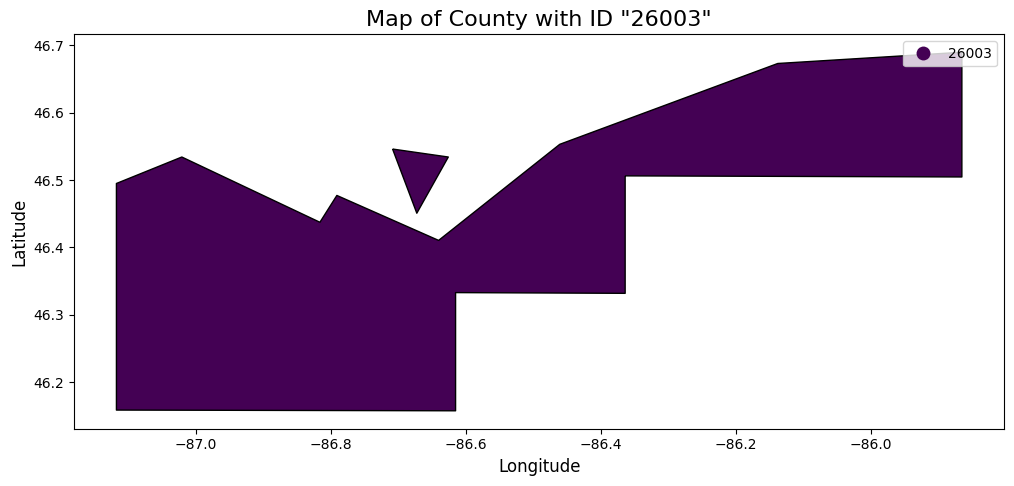

In [36]:
midwest_counties_gdf[midwest_counties_gdf['id'] == '26003']
#merged[merged['id'] == '26003']

county_gdf = counties_gdf[counties_gdf["id"] == "26003"]

# Combine all polygons into a MultiPolygon
county_multipolygon = county_gdf.unary_union

county_multipolygon

county_gdf['geometry'] = county_multipolygon
county_gdf = county_gdf.head(1)
print(county_gdf)   

# Check if the filtered DataFrame is not empty
if county_gdf.empty:
    print("No data found for county '26003'")
else:
    # Plot the specific county
    fig, ax = plt.subplots(figsize=(12, 8))
    county_gdf.plot(ax=ax, edgecolor='black', column='id', cmap='viridis', legend=True)

    # Add title and labels
    ax.set_title('Map of County with ID "26003"', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Show the map
    plt.show()

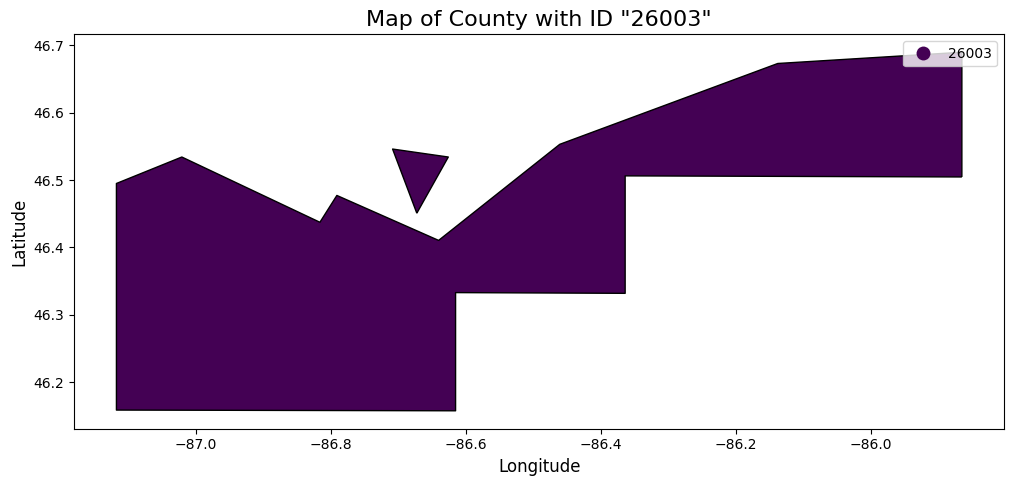

In [30]:
# Configuration
DB_NAME = "field_crops.db"
CROP_TABLE = "midwest_key_field_crops_cleaned"
AREA_TABLE = "midwest_area_planted_cleaned"
OUTPUT_PATH = "../viz/"
MIDWESTERN_STATE_IDS = [17, 18, 19, 20, 26, 27, 29, 31, 38, 39, 46, 55]



import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Query for state_ansi_list
query = f"SELECT DISTINCT state_ansi FROM {AREA_TABLE}"
state_ansi_list = pd.read_sql(query, conn).iloc[:, 0].to_list()

# Filter GeoDataFrame for Midwest counties
midwest_counties_gdf = counties_gdf[
    counties_gdf["id"].str[:2].isin(state_ansi_list)  # Match state ANSI
    & (counties_gdf["id"].str.len() == 5)  # Ensure valid county FIPS codes
]

# Filter for a specific county ('26003' as an example)
test_gdf = counties_gdf[counties_gdf["id"] == "26003"]

# Check if the filtered DataFrame is not empty
if test_gdf.empty:
    print("No data found for county '26003'")
else:
    # Plot the specific county
    fig, ax = plt.subplots(figsize=(12, 8))
    test_gdf.plot(ax=ax, edgecolor='black', column='id', cmap='viridis', legend=True)

    # Add title and labels
    ax.set_title('Map of County with ID "26003"', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Show the map
    plt.show()






In [104]:
df = output_df.sort_values(by=['id', 'year'])

features = ['rolling_avg_production', 'rolling_yield', 'ann_avg_temp', 'ann_avg_precip']

for feature in features:
    first_year_values = df[df["year"] == 1980].set_index("id")[feature]
    df[f"{feature}_1980"] = df["id"].map(first_year_values)
    df[f'{feature}_abs_change_from_1980'] = df[feature] - df[f'{feature}_1980']
    df[f'{feature}_percentage_change_from_1980'] = (df[f'{feature}_abs_change_from_1980'] / df[f'{feature}_1980']) * 100
    df[f'{feature}_percentage_change_from_1980'] = df[f'{feature}_percentage_change_from_1980'].round(2)



df



,id,year,state_name,county_name,rolling_avg_production,rolling_yield,yield_percentile,production_percentile,ann_avg_precip,ann_avg_temp,...,rolling_avg_production_percentage_change_from_1980,rolling_yield_1980,rolling_yield_abs_change_from_1980,rolling_yield_percentage_change_from_1980,ann_avg_temp_1980,ann_avg_temp_abs_change_from_1980,ann_avg_temp_percentage_change_from_1980,ann_avg_precip_1980,ann_avg_precip_abs_change_from_1980,ann_avg_precip_percentage_change_from_1980
4,17001,1980,ILLINOIS,ADAMS,11025360.0,85.10,60,81,3.08,52.00,...,0.00,85.10,0.00,0.00,52.00,0.00,0.00,3.08,0.00,0.00
5,17001,1981,ILLINOIS,ADAMS,11584720.0,91.18,62,81,3.10,52.08,...,5.07,85.10,6.08,7.14,52.00,0.08,0.15,3.08,0.02,0.65
6,17001,1982,ILLINOIS,ADAMS,13052080.0,104.23,75,84,3.14,52.01,...,18.38,85.10,19.13,22.48,52.00,0.01,0.02,3.08,0.06,1.95
7,17001,1983,ILLINOIS,ADAMS,11735160.0,95.75,68,83,3.18,51.94,...,6.44,85.10,10.65,12.51,52.00,-0.06,-0.12,3.08,0.10,3.25
8,17001,1984,ILLINOIS,ADAMS,11084580.0,91.17,61,82,3.22,51.89,...,0.54,85.10,6.07,7.13,52.00,-0.11,-0.21,3.08,0.14,4.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51591,55141,2019,WISCONSIN,WOOD,2950800.0,80.71,7,24,2.77,44.01,...,41.85,51.57,29.14,56.51,42.12,1.89,4.49,2.59,0.18,6.95
51592,55141,2020,WISCONSIN,WOOD,3015400.0,82.25,7,23,2.77,44.02,...,44.96,51.57,30.68,59.49,42.12,1.90,4.51,2.59,0.18,6.95
51593,55141,2021,WISCONSIN,WOOD,2927400.0,81.77,8,23,2.77,44.10,...,40.73,51.57,30.20,58.56,42.12,1.98,4.70,2.59,0.18,6.95
51594,55141,2022,WISCONSIN,WOOD,3508400.0,97.24,15,27,2.78,44.12,...,68.66,51.57,45.67,88.56,42.12,2.00,4.75,2.59,0.19,7.34
